In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pickle
from helpers import helpers_functions

In [2]:
df = pd.read_csv("datasets/tsla_data.csv")

In [3]:
df.head(10)

,date,open,high,low,close,adjClose,volume,unadjustedVolume,change,changePercent,vwap,label,changeOverTime
0,2024-08-15,205.02,215.88,204.82,214.14,214.14,89337569,89337569,9.12,4.450000,209.9650,"August 15, 24",0.044500
1,2024-08-14,207.39,208.44,198.75,201.38,201.38,70250014,70250014,-6.01,-2.900000,203.9900,"August 14, 24",-0.029000
2,2024-08-13,198.47,208.49,197.06,207.83,207.83,76247387,76247387,9.36,4.720000,202.9625,"August 13, 24",0.047200
3,2024-08-12,199.02,199.26,194.67,197.49,197.49,64044903,64044903,-1.53,-0.768770,197.6100,"August 12, 24",-0.007688
4,2024-08-09,197.05,200.88,195.11,200.00,200.00,58648274,58648274,2.95,1.500000,198.2600,"August 09, 24",0.015000
5,2024-08-08,195.70,200.70,192.04,198.84,198.84,65033874,65033874,3.14,1.600000,196.8200,"August 08, 24",0.016000
6,2024-08-07,200.77,203.49,191.48,191.76,191.76,71159778,71159778,-9.01,-4.490000,196.8750,"August 07, 24",-0.044900
7,2024-08-06,200.75,202.90,192.67,200.64,200.64,73783942,73783942,-0.11,-0.054795,199.2400,"August 06, 24",-0.000548
8,2024-08-05,185.22,203.88,182.00,198.88,198.88,100308836,100308836,13.66,7.380000,192.4950,"August 05, 24",0.073800
9,2024-08-02,214.88,216.13,205.78,207.67,207.67,82880120,82880120,-7.21,-3.360000,211.1150,"August 02, 24",-0.033600


In [4]:
train, valid = helpers_functions.tsla_target_eng(df)

c:\Users\MEHMET\Desktop\stock_forecast\helpers\helpers.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.sort_values(by="date", inplace=True)


In [5]:
# We need this after the model
df.sort_values(by="date", inplace=True)
df.set_index("date",inplace=True)

In [6]:
train.head(10)

,close
date,
2019-08-19,15.12
2019-08-20,15.06
2019-08-21,14.72
2019-08-22,14.81
2019-08-23,14.09
2019-08-26,14.33
2019-08-27,14.27
2019-08-28,14.37
2019-08-29,14.78


In [7]:
valid.head(10)

,close
date,
2023-08-16,225.60
2023-08-17,219.22
2023-08-18,215.49
2023-08-21,231.28
2023-08-22,233.19
2023-08-23,236.86
2023-08-24,230.04
2023-08-25,238.59
2023-08-28,238.82


In [8]:
lags = np.arange(1,6)

In [9]:
train = helpers_functions.lag_features(train,lags,"close")
valid = helpers_functions.lag_features(valid,lags,"close")

In [10]:
train

,close,lag_1,lag_2,lag_3,lag_4,lag_5
date,,,,,,
2019-08-19,15.12,NaN,NaN,NaN,NaN,NaN
2019-08-20,15.06,15.12,NaN,NaN,NaN,NaN
2019-08-21,14.72,15.06,15.12,NaN,NaN,NaN
2019-08-22,14.81,14.72,15.06,15.12,NaN,NaN
2019-08-23,14.09,14.81,14.72,15.06,15.12,NaN
...,...,...,...,...,...,...
2023-08-09,242.19,249.70,251.45,253.86,259.32,254.11
2023-08-10,245.34,242.19,249.70,251.45,253.86,259.32
2023-08-11,242.65,245.34,242.19,249.70,251.45,253.86


In [11]:
valid

,close,lag_1,lag_2,lag_3,lag_4,lag_5
date,,,,,,
2023-08-16,225.60,NaN,NaN,NaN,NaN,NaN
2023-08-17,219.22,225.60,NaN,NaN,NaN,NaN
2023-08-18,215.49,219.22,225.60,NaN,NaN,NaN
2023-08-21,231.28,215.49,219.22,225.60,NaN,NaN
2023-08-22,233.19,231.28,215.49,219.22,225.60,NaN
...,...,...,...,...,...,...
2024-08-09,200.00,198.84,191.76,200.64,198.88,207.67
2024-08-12,197.49,200.00,198.84,191.76,200.64,198.88
2024-08-13,207.83,197.49,200.00,198.84,191.76,200.64


In [12]:
train_X, train_y = helpers_functions.separate_features(train)

In [13]:
valid_X, valid_y = helpers_functions.separate_features(valid)

In [14]:
lgbm_model = LGBMRegressor()

In [15]:
lgbm_model.fit(train_X, train_y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1005, number of used features: 5
[LightGBM] [Info] Start training from score 188.337691


LGBMRegressor()

In [16]:
y_pred = lgbm_model.predict(valid_X)

In [17]:
print(mean_absolute_error(valid_y,y_pred))

7.052391491932014


In [18]:
print(mean_squared_error(valid_y,y_pred))

246.14664814456202


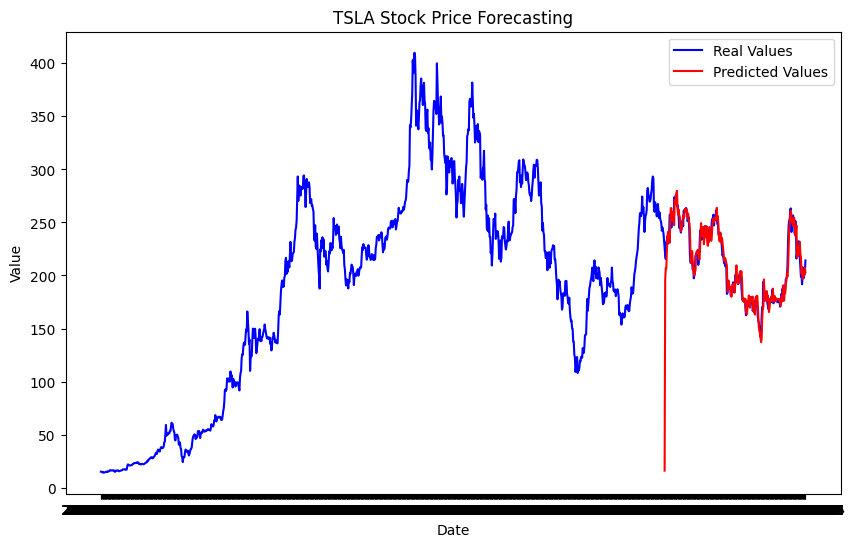

In [19]:

predicted_dates = valid_X.index

plt.figure(figsize=(10, 6))
plt.plot(df.index, df['close'], label='Real Values', color='blue')
plt.plot(predicted_dates, y_pred, label='Predicted Values', color='red')
plt.title('TSLA Stock Price Forecasting')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [20]:
with open('lgbm_target_model.pkl', 'wb') as f:
    pickle.dump(lgbm_model, f)

In [21]:
valid_X.to_csv("datasets/lgbm_val_x.csv")
valid_y.to_csv("datasets/lgbm_val_y.csv")